# Amylase production

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
from bacillusme.analysis import sensitivity as ss


import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [90]:
for r in me.reactions:
    if 'post' in r.id:
        print(r.id,r.reaction)
        break

In [72]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')
ibsu_directory = join(flat_files.ecoli_files_dir, 'iBsu1103.json') 

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)
ibsu = cobra.io.load_json_model(ibsu_directory)

bsub.optimize()

<Solution 0.12 at 0x7f47233afcf8>

# Chen

### Reported data

In [73]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [257]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3811186/ -> 256 U/mg protein, A. amilolytica
# Abdel-Naby, et al. 1999 -> 22.58 U/mg protein (B. subtilis)
# Normurodova et al. 2007 -> 153.7
specific_activity_min = 153.7 # U/mg
specific_activity_max = 245
molecular_weight = me.metabolites.get_by_id('BSU03040-MONOMER').formula_weight # mg/mmol

In [8]:
# Chen et al., 2015.
t_exp = np.array([0,6,12,18,24]) # h
X_exp = np.array([0.033,2.28,5.40,6.40,6.80]) # g/L
C_exp = np.array([0,61.752,133.52,393.88,515.72]) # U/mL

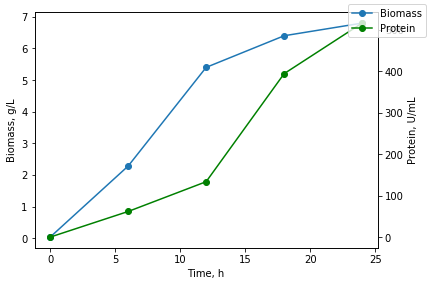

In [9]:
fig,ax = plt.subplots()
ax.plot(t_exp,X_exp,'-o', label ='Biomass')
ax.set_xlabel('Time, h')
ax.set_ylabel('Biomass, g/L')

ax2 = ax.twinx()
ax2.plot(t_exp,C_exp,'-o',color='g',label='Protein')
ax2.set_xlabel('Time, h')
ax2.set_ylabel('Protein, U/mL')

fig.legend()
fig.tight_layout()

In [67]:
# Take only exponential phase
i = 0
j = 5
t = t_exp[i:j]
X = X_exp[i:j]
C = C_exp[i:j]

In [68]:
from sklearn.linear_model import LinearRegression
mu_model = LinearRegression().fit(t.reshape(-1,1),np.log(X).reshape(-1,1))
mu_model.coef_,mu_model.intercept_

(array([[0.19480772]]), array([-1.76318319]))

In [69]:
mu_exp = mu_model.coef_[0][0]
mu_exp

0.19480772011324515

In [258]:
integral = np.trapz(X,t)
v_exp = (C[-1]-C[0])/integral # U/gDW h
v_exp = v_exp/specific_activity_min # mg/gDW h
v_exp = v_exp/molecular_weight # mmolE/gDW h
v_exp_max = v_exp
v_exp_max

4.416758274350314e-07

In [259]:
v_exp_min = v_exp*specific_activity_min/specific_activity_max
v_exp_min

2.7708397827250746e-07

### Choosing  uptake ranges

In [73]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [74]:
me.reactions.get_by_id('EX_glc__D_e').lower_bound= 0
me.reactions.get_by_id('EX_nh4_e').lower_bound= -10
me.reactions.get_by_id('EX_starch_e').lower_bound= -2.0

In [628]:
solve_me_model(me, max_mu = 1.0, min_mu = .0, using_soplex=False,
                   precision = 1e-6,verbosity=2,mu_fix=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 209.626682 seconds
Finished substituting S,lb,ub in 9.110255 seconds
Finished makeME_LP in 1.100688 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 9.109383 seconds
Finished makeME_LP in 1.088372 seconds
Getting MINOS parameters from ME_NLP...
2 0.25 0.25 0.5 0.25 optimal
Finished substituting S,lb,ub in 9.094610 seconds
Finished makeME_LP in 1.107664 seconds
Getting MINOS parameters from ME_NLP...
3 0.25 0.25 0.375 0.375 1
Finished substituting S,lb,ub in 9.085462 seconds
Finished makeME_LP in 1.093825 seconds
Getting MINOS parameters from ME_NLP...
4 0.25 0.25 0.3125 0.3125 1
Finished substituting S,lb,ub in 8.953362 seconds
Finished makeME_LP in 1.098524 seconds
Getting MINOS parameters from ME_NLP...
5 0.25 0.25 0.28125 0.28125 1
Finished substituting S,lb,ub in 8.889711 seconds
Finished makeME_LP in 1.094858 seconds
Getting MINOS parameters from ME_N

In [85]:
val = -1.47
inc = val*0.1/10
rates = np.arange(val*0.9,val+inc,inc)
rates

array([-1.323 , -1.3377, -1.3524, -1.3671, -1.3818, -1.3965, -1.4112,
       -1.4259, -1.4406, -1.4553, -1.47  ])

In [86]:
def single_flux_response(me,rate):
    me.reactions.get_by_id('EX_starch_e').lower_bound= rate
    solve_me_model(me, max_mu = 1.0, min_mu = .0, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=False)
    return rate, me.solution.x_dict

In [87]:
new_mu=False
flux_dict = dict()
import multiprocessing as mp
NP = min([len(rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in rates:
    pool.apply_async(single_flux_response, args=(me,rate), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Calculating with 10 cores


,-1.4700,-1.4553,-1.4406,-1.4259,-1.4112,-1.3965,-1.3818,-1.3671,-1.3524,-1.3377,-1.3230
biomass_dilution,0.195480,0.193248,0.191015,0.188782,0.186548,0.184314,0.182080,0.179845,0.177610,0.175375,0.173139
protein_biomass_to_biomass,0.067561,0.066816,0.066071,0.065325,0.064578,0.063831,0.063083,0.062334,0.061585,0.060835,0.060084
mRNA_biomass_to_biomass,0.000266,0.000262,0.000258,0.000254,0.000250,0.000246,0.000242,0.000239,0.000235,0.000231,0.000227
tRNA_biomass_to_biomass,0.001615,0.001591,0.001567,0.001543,0.001520,0.001496,0.001473,0.001450,0.001427,0.001404,0.001381
rRNA_biomass_to_biomass,0.011671,0.011498,0.011326,0.011154,0.010984,0.010814,0.010646,0.010478,0.010311,0.010145,0.009980


In [443]:
flux_responses_me.to_csv('amylose_production_flux_responses_chen.csv')

In [115]:
flux_responses_me = pd.read_csv('amylose_production_flux_responses_chen.csv',index_col=0)

,-1.4699999999999993,-1.4552999999999994,-1.4405999999999994,-1.4258999999999995,-1.4111999999999996,-1.3964999999999996,-1.3817999999999997,-1.3670999999999998,-1.3523999999999998,-1.3377,-1.323
biomass_dilution,1.954803e-01,0.193248,0.191015,0.188782,0.186548,0.184314,0.182080,0.179845,0.177610,0.175375,0.173139
protein_biomass_to_biomass,6.756097e-02,0.066816,0.066071,0.065325,0.064578,0.063831,0.063083,0.062334,0.061585,0.060835,0.060084
mRNA_biomass_to_biomass,2.657419e-04,0.000262,0.000258,0.000254,0.000250,0.000246,0.000242,0.000239,0.000235,0.000231,0.000227
tRNA_biomass_to_biomass,1.614867e-03,0.001591,0.001567,0.001543,0.001520,0.001496,0.001473,0.001450,0.001427,0.001404,0.001381
rRNA_biomass_to_biomass,1.167057e-02,0.011498,0.011326,0.011154,0.010984,0.010814,0.010646,0.010478,0.010311,0.010145,0.009980
...,...,...,...,...,...,...,...,...,...,...,...
translocation_BSU39410,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translocation_BSU39450,5.187275e-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translocation_BSU39710,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translocation_BSU40070,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


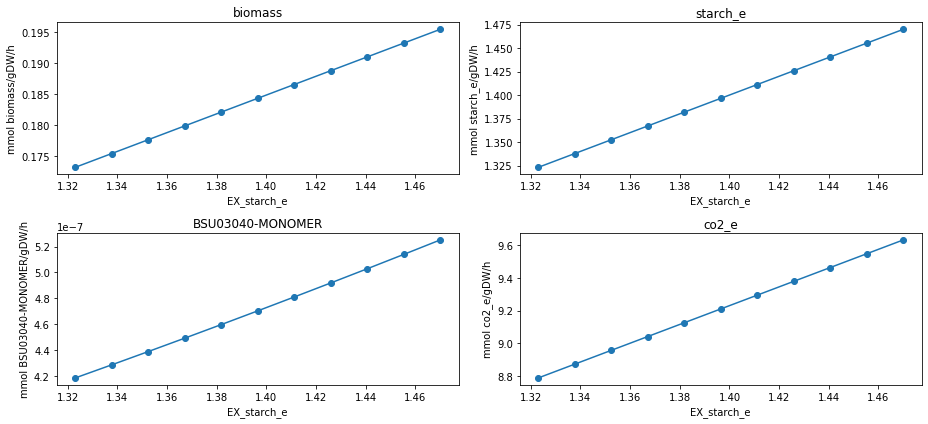

In [90]:
get_met_production(me,['biomass','starch_e','BSU03040-MONOMER','co2_e'],flux_responses_me,'EX_starch_e')

### Random sampling

In [444]:
flux_responses_me = pd.read_csv('amylose_production_flux_responses_chen.csv',index_col=0)

In [229]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [191]:
me.reactions.get_by_id('EX_glc__D_e').lower_bound= 0
me.reactions.get_by_id('EX_nh4_e').lower_bound= -10
me.reactions.get_by_id('EX_starch_e').lower_bound= -2.0

In [216]:
df = exchange_single_model(me,flux_dict=flux_responses_me.iloc[:,-1].to_dict())
df = df[df['flux'].abs()>1e0]
df0 = df.loc[df['flux'].abs().sort_values(ascending=False).index]

In [218]:
df = exchange_single_model(me,flux_dict=flux_responses_me.iloc[:,0].to_dict())
df = df[df['flux'].abs()>1e0]
dff = df.loc[df['flux'].abs().sort_values(ascending=False).index]

In [237]:
sample_df = df0['flux'].to_frame().join(dff['flux'].to_frame(),lsuffix='_0',rsuffix='_f').T
sample_dict = sample_df.to_dict()
sample_df.T

,flux_0,flux_f
id,,
EX_h2o_e,10.286463,10.500307
EX_co2_e,8.860528,9.034872
EX_o2_e,-8.415687,-8.584239
EX_nh4_e,-1.595786,-1.647670
EX_h_e,1.337943,1.385999
EX_starch_e,-1.335871,-1.365991


In [221]:
import random
def single_flux_response(me,sample_dict,idx):
    for r in sample_dict:
        rxn = me.reactions.get_by_id(r)
        rate_0 = sample_dict[r]['flux_0']
        rate_f = sample_dict[r]['flux_f']
        rate = rate_0 + random.uniform(0,1)*(rate_f-rate_0)
        
        # Set maximum values
        if rate < 0:
            rxn.lower_bound = rate
        else:
            rxn.upper_bound = rate
            
    solve_me_model(me, max_mu = 1.0, min_mu = .0, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=False)
    return str(idx), me.solution.x_dict

In [ ]:
new_mu=False
flux_dict = dict()
import multiprocessing as mp
NP = min([len(rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for i in range(0,100):
    pool.apply_async(single_flux_response, args=(me,sample_dict,i), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Calculating with 10 cores


In [260]:
flux_responses_me.to_csv('rnd_amylose_flux_responses_chen.csv')

In [425]:
flux_responses_me = pd.read_csv('rnd_amylose_flux_responses_chen.csv',index_col=0)

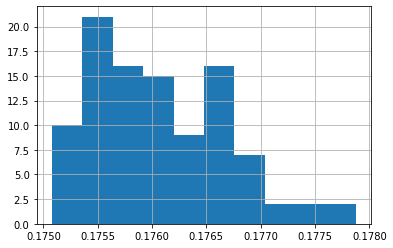

In [426]:
flux_responses_me.loc['biomass_dilution'].hist()

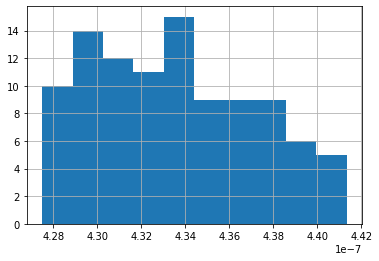

In [427]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].hist()

In [428]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].mean()

4.335843882192743e-07

In [429]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].std()

3.6908960279810044e-09

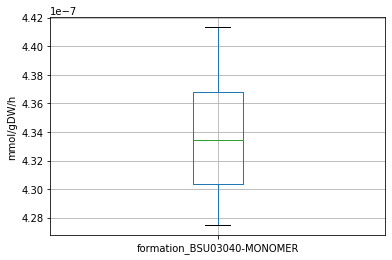

In [431]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].to_frame().boxplot()

plt.ylabel('mmol/gDW/h')
plt.savefig('figures/amylose_sampling_chen.svg',format='SVG')

# Ma

### Reported data

In [6]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [262]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3811186/ -> 256 U/mg protein, A. amilolytica
# Abdel-Naby, et al. 1999 -> 22.58 U/mg protein (B. subtilis)
# Normurodova et al. 2007 -> 153.7
specific_activity_min = 153.7 # U/mg
specific_activity_max = 245
molecular_weight = me.metabolites.get_by_id('BSU03040-MONOMER').formula_weight # mg/mmol

In [266]:
# Ma et al., 2016
t_exp = np.array([8,16,24,32]) # h
X_exp = np.array([3.03,4.85,6.03,5.61]) # g/L
C_exp = np.array([8.71,13.46,23.76,50.69]) # U/mL

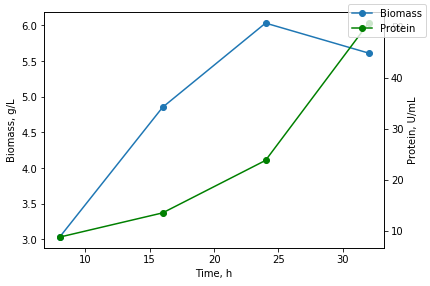

In [267]:
fig,ax = plt.subplots()
ax.plot(t_exp,X_exp,'-o', label ='Biomass')
ax.set_xlabel('Time, h')
ax.set_ylabel('Biomass, g/L')

ax2 = ax.twinx()
ax2.plot(t_exp,C_exp,'-o',color='g',label='Protein')
ax2.set_xlabel('Time, h')
ax2.set_ylabel('Protein, U/mL')

fig.legend()
fig.tight_layout()

In [302]:
# Take only exponential phase
i = 0
j = -1
t = t_exp[i:j]
X = X_exp[i:j]
C = C_exp[i:j]

In [303]:
from sklearn.linear_model import LinearRegression
mu_model = LinearRegression().fit(t.reshape(-1,1),np.log(X).reshape(-1,1))
mu_model.coef_,mu_model.intercept_

(array([[0.04301152]]), array([0.80657839]))

In [304]:
mu_exp = mu_model.coef_[0][0]
mu_exp

0.04301152445111352

In [300]:
integral = np.trapz(X,t)
v_exp = (C[-1]-C[0])/integral # U/gDW h
v_exp = v_exp/specific_activity_min # mg/gDW h
v_exp = v_exp/molecular_weight # mmolE/gDW h
v_exp_max = v_exp
v_exp_max

1.354875812140388e-08

In [301]:
v_exp_min = v_exp*specific_activity_min/specific_activity_max
v_exp_min

8.499771931672557e-09

### Choosing  uptake ranges

In [273]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [315]:
me.reactions.get_by_id('EX_glc__D_e').lower_bound= 0
me.reactions.get_by_id('EX_nh4_e').lower_bound= -10
me.reactions.get_by_id('EX_starch_e').lower_bound= -0.47

In [316]:
solve_me_model(me, max_mu = 1.0, min_mu = .0, using_soplex=False,
                   precision = 1e-6,verbosity=2,mu_fix=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 207.261305 seconds
Finished substituting S,lb,ub in 9.068345 seconds
Finished makeME_LP in 1.120679 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 8.981113 seconds
Finished makeME_LP in 1.117597 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 8.994176 seconds
Finished makeME_LP in 1.121104 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 8.920549 seconds
Finished makeME_LP in 1.123502 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 8.849396 seconds
Finished makeME_LP in 1.123604 seconds
Getting MINOS parameters from ME_NLP...
5 0.03125 0.03125 0.0625 0.03125 optimal
Finished substituting S,lb,ub in 9.019332 seconds
Finished makeME_LP in 1.124729 seconds
Getting MINOS parameters from ME_N

In [317]:
me.solution.f

0.04283618927001953

In [318]:
val = -0.47
inc = val*0.1/10
rates = np.arange(val*0.9,val+inc,inc)
rates

array([-0.423 , -0.4277, -0.4324, -0.4371, -0.4418, -0.4465, -0.4512,
       -0.4559, -0.4606, -0.4653, -0.47  ])

In [319]:
def single_flux_response(me,rate):
    me.reactions.get_by_id('EX_starch_e').lower_bound= rate
    solve_me_model(me, max_mu = 1.0, min_mu = .0, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=False)
    return rate, me.solution.x_dict

In [320]:
new_mu=False
flux_dict = dict()
import multiprocessing as mp
NP = min([len(rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in rates:
    pool.apply_async(single_flux_response, args=(me,rate), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Calculating with 10 cores


,-0.4700,-0.4653,-0.4606,-0.4559,-0.4512,-0.4465,-0.4418,-0.4371,-0.4324,-0.4277,-0.4230
biomass_dilution,0.042836,0.042115,0.041394,0.040673,0.039952,0.039231,0.038510,0.037789,0.037068,0.036347,0.035626
protein_biomass_to_biomass,0.015247,0.014992,0.014738,0.014483,0.014228,0.013974,0.013719,0.013464,0.013209,0.012954,0.012699
mRNA_biomass_to_biomass,0.000044,0.000043,0.000043,0.000042,0.000041,0.000040,0.000039,0.000039,0.000038,0.000037,0.000036
tRNA_biomass_to_biomass,0.000269,0.000264,0.000259,0.000254,0.000249,0.000244,0.000239,0.000234,0.000230,0.000225,0.000220
rRNA_biomass_to_biomass,0.001944,0.001908,0.001873,0.001837,0.001802,0.001767,0.001732,0.001697,0.001662,0.001627,0.001592


In [321]:
flux_responses_me.to_csv('amylose_production_flux_responses_ma.csv')

In [1488]:
flux_responses_me = pd.read_csv('amylose_production_flux_responses_ma.csv',index_col=0)

100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


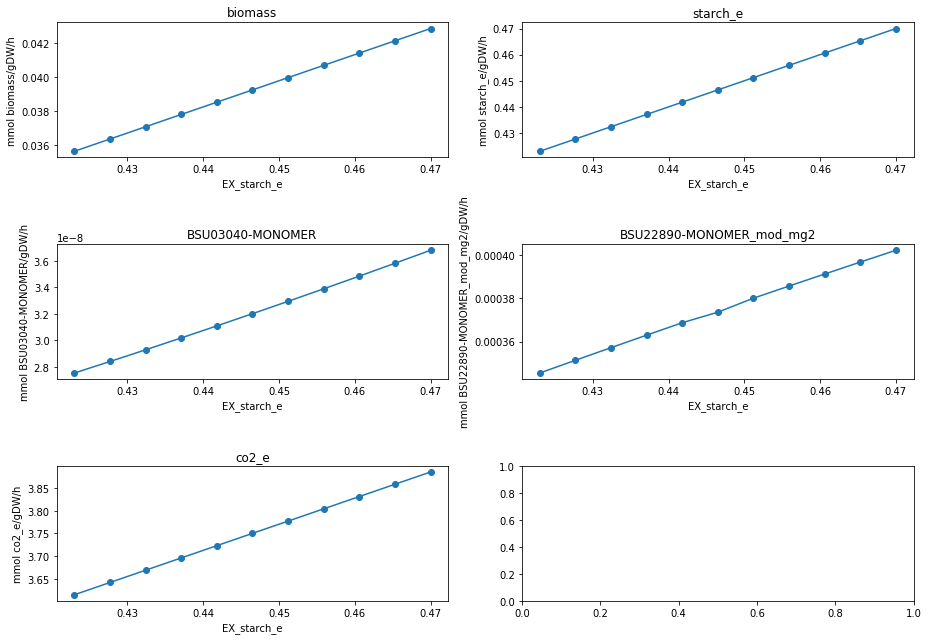

In [1489]:
get_met_production(me,['biomass','starch_e','BSU03040-MONOMER','BSU22890-MONOMER_mod_mg2','co2_e'],flux_responses_me,'EX_starch_e')

### Random sampling

In [324]:
flux_responses_me = pd.read_csv('amylose_production_flux_responses_ma.csv',index_col=0)

In [ ]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [ ]:
me.reactions.get_by_id('EX_glc__D_e').lower_bound= 0
me.reactions.get_by_id('EX_nh4_e').lower_bound= -10
me.reactions.get_by_id('EX_starch_e').lower_bound= -2.0

In [ ]:
df = exchange_single_model(me,flux_dict=flux_responses_me.iloc[:,-1].to_dict())
df = df[df['flux'].abs()>1e0]
df0 = df.loc[df['flux'].abs().sort_values(ascending=False).index]

In [ ]:
df = exchange_single_model(me,flux_dict=flux_responses_me.iloc[:,0].to_dict())
df = df[df['flux'].abs()>1e0]
dff = df.loc[df['flux'].abs().sort_values(ascending=False).index]

In [ ]:
sample_df = df0['flux'].to_frame().join(dff['flux'].to_frame(),lsuffix='_0',rsuffix='_f').T
sample_dict = sample_df.to_dict()
sample_df.T

In [221]:
import random
def single_flux_response(me,sample_dict,idx):
    for r in sample_dict:
        rxn = me.reactions.get_by_id(r)
        rate_0 = sample_dict[r]['flux_0']
        rate_f = sample_dict[r]['flux_f']
        rate = rate_0 + random.uniform(0,1)*(rate_f-rate_0)
        
        # Set maximum values
        if rate < 0:
            rxn.lower_bound = rate
        else:
            rxn.upper_bound = rate
            
    solve_me_model(me, max_mu = 1.0, min_mu = .0, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=False)
    return str(idx), me.solution.x_dict

In [ ]:
new_mu=False
flux_dict = dict()
import multiprocessing as mp
NP = min([len(rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for i in range(0,100):
    pool.apply_async(single_flux_response, args=(me,sample_dict,i), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Calculating with 10 cores


In [388]:
flux_responses_me.to_csv('rnd_amylose_flux_responses_ma.csv')

In [432]:
flux_responses_me = pd.read_csv('rnd_amylose_flux_responses_ma.csv',index_col=0)

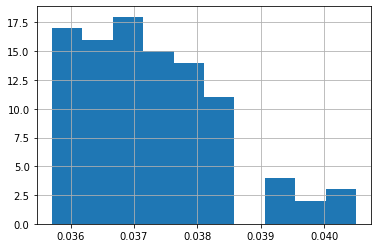

In [433]:
flux_responses_me.loc['biomass_dilution'].hist()

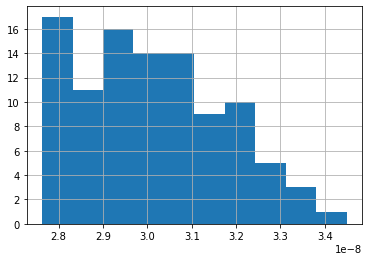

In [434]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].hist()

In [435]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].mean()

3.0122257506841536e-08

In [436]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].std()

1.60999927232764e-09

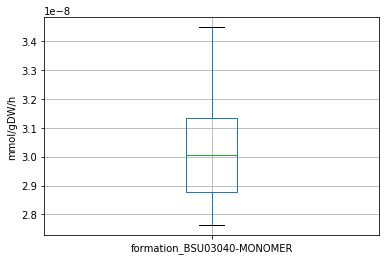

In [437]:
flux_responses_me.loc['formation_BSU03040-MONOMER'].to_frame().boxplot()

plt.ylabel('mmol/gDW/h')
plt.savefig('figures/amylose_sampling_ma.svg',format='SVG')

# Both

In [1248]:
flux_responses_me_chen = pd.read_csv('rnd_amylose_flux_responses_chen.csv',index_col=0)
flux_responses_me_ma = pd.read_csv('rnd_amylose_flux_responses_ma.csv',index_col=0)

In [1249]:
r = 'formation_BSU03040-MONOMER'
df = flux_responses_me_ma.loc[r].to_frame().join(flux_responses_me_chen.loc[r].to_frame(),rsuffix='_chen',lsuffix='_ma')

In [1250]:
v_exp_min_chen = 2.7708397827250746e-07
v_exp_max_chen = 4.416758274350314e-07

v_exp_min_ma = 1.354875812140388e-08
v_exp_max_ma = 8.499771931672557e-09

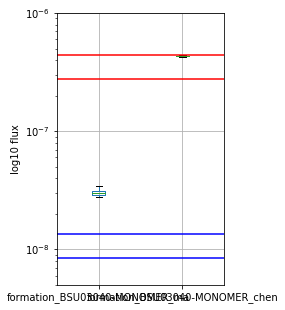

In [1259]:
df.boxplot(figsize=(3,5))
plt.axhline(v_exp_max_chen, c='r')
plt.axhline(v_exp_min_chen, c='r')
plt.axhline(v_exp_max_ma, c='b')
plt.axhline(v_exp_min_ma, c='b')


plt.ylabel('log10 flux')
plt.yscale('log')
plt.ylim([0.5e-8,1e-6])
plt.savefig('figures/sample_amylose_production_both.svg',format='SVG')

# PCA

In [1876]:
flux_responses_me_chen = pd.read_csv('rnd_amylose_flux_responses_chen.csv',index_col=0)
flux_responses_me_ma = pd.read_csv('rnd_amylose_flux_responses_ma.csv',index_col=0)

In [1877]:
flux_responses_me = flux_responses_me_ma.join(flux_responses_me_chen,rsuffix='_chen',lsuffix='_ma')
flux_responses_me

,0_ma,1_ma,10_ma,11_ma,12_ma,13_ma,14_ma,15_ma,16_ma,17_ma,...,90_chen,91_chen,92_chen,93_chen,94_chen,95_chen,96_chen,97_chen,98_chen,99_chen
biomass_dilution,0.036184,0.037023,3.802204e-02,3.675461e-02,0.037845,0.035703,0.035980,0.036468,3.666306e-02,0.038279,...,1.753702e-01,0.175639,0.175412,1.755590e-01,1.751738e-01,0.175822,0.175888,0.176082,0.175076,1.753950e-01
protein_biomass_to_biomass,0.012896,0.013193,1.353866e-02,1.310997e-02,0.013477,0.012726,0.012824,0.012996,1.307758e-02,0.013637,...,6.084400e-02,0.060946,0.060837,6.090627e-02,6.078703e-02,0.060976,0.061005,0.061064,0.060730,6.084378e-02
mRNA_biomass_to_biomass,0.000037,0.000038,3.933043e-05,3.744846e-05,0.000039,0.000036,0.000037,0.000037,3.734737e-05,0.000039,...,2.310475e-04,0.000231,0.000231,2.314893e-04,2.307311e-04,0.000232,0.000232,0.000233,0.000231,2.312525e-04
tRNA_biomass_to_biomass,0.000224,0.000229,2.383772e-04,2.267999e-04,0.000236,0.000220,0.000222,0.000226,2.261910e-04,0.000238,...,1.400354e-03,0.001405,0.001405,1.403352e-03,1.400056e-03,0.001410,0.001409,0.001413,0.001401,1.405814e-03
rRNA_biomass_to_biomass,0.001619,0.001659,1.728932e-03,1.645430e-03,0.001720,0.001596,0.001609,0.001633,1.640989e-03,0.001720,...,1.014630e-02,0.010162,0.010160,1.016274e-02,1.012918e-02,0.010190,0.010186,0.010210,0.010129,1.015568e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
translocation_BSU39410,0.000000,0.000000,-3.275863e-31,-2.190940e-29,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000,1.269637e-62,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-4.944262e-29
translocation_BSU39450,0.000000,0.000000,0.000000e+00,-6.074726e-62,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,-9.895119e-35,0.000000,0.000000,2.015310e-29,4.305994e-28,0.000000,0.000000,0.000000,0.000000,1.010671e-29
translocation_BSU39710,0.000000,0.000000,0.000000e+00,3.202354e-28,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000,9.196043e-28,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.305499e-28
translocation_BSU40070,0.000000,0.000000,0.000000e+00,-1.194395e-29,0.000000,0.000000,0.000000,0.000000,-3.713700e-29,0.000000,...,-2.574911e-29,0.000000,0.000000,0.000000e+00,4.289461e-29,0.000000,0.000000,0.000000,0.000000,1.140916e-62


In [1878]:
from sklearn.decomposition import PCA

rxns = [i.id for i in me.reactions if isinstance(i,cobrame.MetabolicReaction) or 'EX_'in i.id]
data = flux_responses_me.loc[rxns]
data = data[data.any(axis=1)] # All active reactions
data = data[data.std(axis=1).abs()>0] # Reactions that change
# data = data.abs()
data

,0_ma,1_ma,10_ma,11_ma,12_ma,13_ma,14_ma,15_ma,16_ma,17_ma,...,90_chen,91_chen,92_chen,93_chen,94_chen,95_chen,96_chen,97_chen,98_chen,99_chen
EX_2ddglcn_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_2hxmp_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.975617e-49,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.628197e-22,0.000000e+00
EX_5mtr_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_Larab_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_Lcyst_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.695607e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLK_FWD_BSU17610-MONOMER_mod_mg2,0.000000e+00,0.000000e+00,-6.306749e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.821849e-35,0.000000e+00,0.000000e+00,...,0.000000e+00,-3.191380e-23,0.000000e+00,1.628484e-29,-1.990334e-28,0.000000e+00,-1.450730e-28,-2.384366e-31,3.564572e-33,3.503447e-24
XYLt2_FWD_BSU33960-MONOMER,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.010929e-56,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
BALAt2r_FWD_BSU06310-MONOMER,0.000000e+00,0.000000e+00,0.000000e+00,4.802214e-19,4.944758e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
COBALTt5_FWD_SPONT,5.810318e-09,5.872838e-09,6.427140e-09,7.707796e-09,8.568581e-09,5.449502e-09,5.537126e-09,5.693947e-09,7.669263e-09,6.291258e-09,...,1.717001e-07,1.797820e-07,1.702459e-07,1.754621e-07,1.779575e-07,1.707261e-07,1.649582e-07,1.730678e-07,1.653585e-07,1.749160e-07


In [1879]:
X = data.values
X.shape

(1253, 200)

In [1880]:
X_mean = X.mean(axis=1).reshape(-1,1) * np.ones((1,X.shape[1]))
X_std = X.std(axis=1).reshape(-1,1) * np.ones((1,X.shape[1]))

In [1881]:
X_mean.shape

(1253, 200)

In [1887]:
Z = ((X-X_mean)/X_std).T

In [1888]:
pca = PCA(n_components = 3)
pca.fit(Z)
X_ = pca.transform(Z)
var = pca.explained_variance_ratio_
components = pca.components_.T
print(X_.shape,pca.components_.shape,var)

(200, 3) (3, 1253) [0.30335408 0.03295216 0.02644088]


(-10, 15)

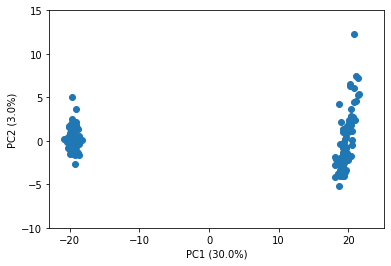

In [1889]:
pc_id = [0,1]
plt.scatter(X_[:,pc_id[0]],X_[:,pc_id[1]])
plt.xlabel('PC{} ({}%)'.format(pc_id[0]+1,round(var[pc_id[0]],2)*100))
plt.ylabel('PC{} ({}%)'.format(pc_id[1]+1,round(var[pc_id[1]],2)*100))
plt.ylim([-10,15])

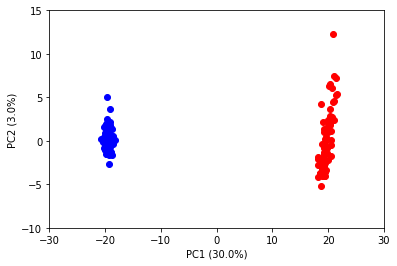

In [1890]:
pc_id = [0,1]
for i in range(0,X_.shape[0]):
    sample = data.columns.values[i]
    row = X_[i,pc_id]
    color = 'r' if '_ma' in sample else 'b'
    plt.scatter(row[0],row[1],color=color)
plt.ylim([-10,15])
plt.xlabel('PC{} ({}%)'.format(pc_id[0]+1,round(var[pc_id[0]],2)*100))
plt.ylabel('PC{} ({}%)'.format(pc_id[1]+1,round(var[pc_id[1]],2)*100))
plt.ylim([-10,15])
plt.xlim([-30,30])
plt.savefig('figures/PCA_amylase.svg',format='SVG')

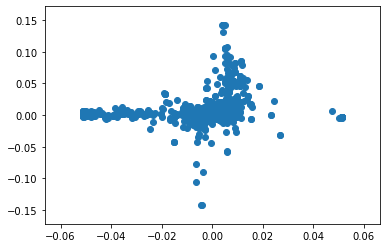

In [1891]:
pc_id = [0,1]
plt.scatter(components[:,pc_id[0]],components[:,pc_id[1]])

In [1892]:
pca_df = pd.DataFrame(data=pca.components_.T,index=data.index)
pca_df.abs().sort_values(by=0,ascending=False)

,0,1,2
RBFSa_FWD_CPLX8J2-124,0.051262,0.003196,0.002768
DB4PS_FWD_BSU23260-MONOMER,0.051262,0.003196,0.002768
DHPPDA_FWD_BSU23280-MONOMER,0.051262,0.003196,0.002768
GTPCII_FWD_BSU23260-MONOMER,0.051262,0.003196,0.002768
APRAUR_FWD_BSU23280-MONOMER,0.051262,0.003196,0.002768
...,...,...,...
PROt2r_FWD_BSU30530-MONOMER,0.000126,0.018873,0.075346
CSNt2_FWD_BSU38710-MONOMER,0.000073,0.000568,0.003463
EDA_FWD_BSU22100-MONOMER,0.000057,0.013447,0.026786
UAG2EMA_REV_BSU35660-MONOMER_mod_nad,0.000042,0.007366,0.028562


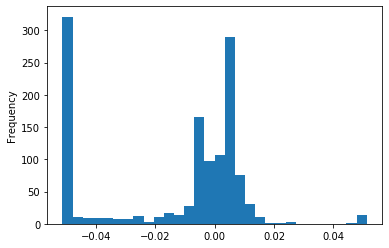

In [1893]:
pca_df[0].sort_values(ascending=False).plot.hist(bins=30)

In [1894]:
rxn_subsystem = defaultdict()
for r in bsub.reactions:
    eco_r = get_identical_reactions(eco,r)
    if eco_r:
        eco_subs = [r.subsystem for r in eco_r]
        rxn_subsystem[r.id] = eco_subs[0]
    else:
        rxn_subsystem[r.id] = r.subsystem

In [1895]:
df = pca_df
# df = df[df[0]> 0.5*df[0].max()]
red_pca_df = df
red_pca_df

,0,1,2
EX_2ddglcn_e,0.004276,0.142396,-0.058298
EX_2hxmp_e,-0.001122,0.022332,0.087560
EX_5mtr_e,0.001179,-0.003621,0.020875
EX_Larab_e,-0.003581,-0.002750,-0.004487
EX_Lcyst_e,0.006818,0.025164,0.095375
...,...,...,...
XYLK_FWD_BSU17610-MONOMER_mod_mg2,-0.006581,-0.019127,-0.070790
XYLt2_FWD_BSU33960-MONOMER,-0.000573,-0.044143,0.038319
BALAt2r_FWD_BSU06310-MONOMER,0.024553,0.022688,0.006965
COBALTt5_FWD_SPONT,-0.051180,0.003852,0.002907


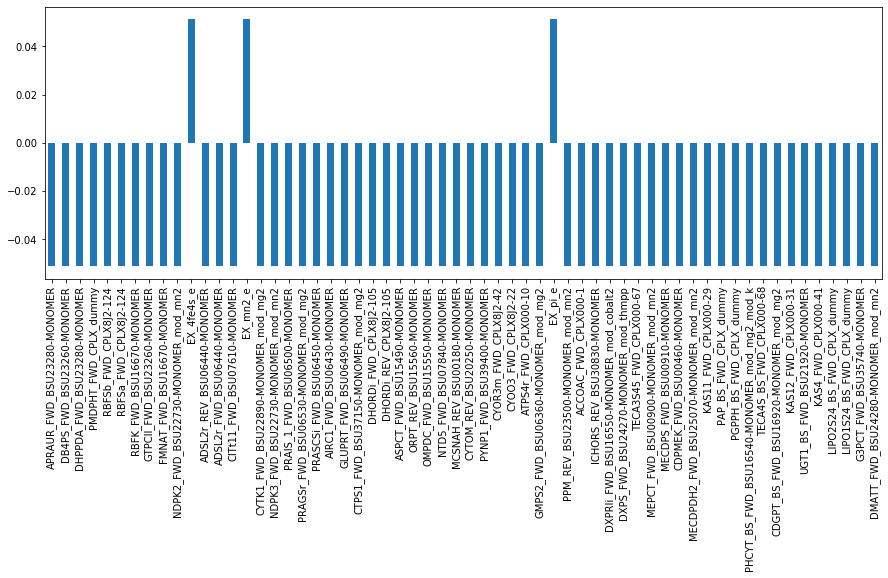

In [1896]:
pca_df.loc[pca_df[0].abs().sort_values(ascending=False).index].head(60)[0].plot.bar(figsize=(15,5))

In [1897]:
from collections import defaultdict
pca_weights = defaultdict(defaultdict)
count_dict = defaultdict(int)
j = 0
for r,row in red_pca_df.iterrows():
    rxn = me.reactions.get_by_id(r)
    m_r = rxn.stoichiometric_data.id if hasattr(rxn,'stoichiometric_data') else rxn.subsystem
#     subsystem = rxn_subsystem[m_r] if m_r in rxn_subsystem else rxn.subsystem
#     subsystem = rxn.subsystem
    subsystem = r
    count_dict[subsystem] += 1
    if 'Salvage' in subsystem:
        print(r,me.reactions.get_by_id(r).reaction,row[0])
    for i in row.to_dict():
        if subsystem not in pca_weights[int(i)]:
            pca_weights[int(i)][subsystem] = 0
        pca_weights[int(i)][subsystem] += row[i]*(X[j,101:].mean() - X[j,:100].mean())
    j += 1  

In [1898]:
count_df = pd.DataFrame.from_dict({'count':count_dict})
count_df

,count
2HXMPt6_REV_CPLX_dummy,1
2PGt6_REV_CPLX_dummy,1
2S6HCCi_FWD_BSU30820-MONOMER,1
5MTRt2_REV_CPLX_dummy,1
AAMYL_1_FWD_BSU03040-MONOMER,1
...,...
XYLI1_FWD_BSU17600-MONOMER,1
XYLI1_REV_BSU17600-MONOMER,1
XYLI2_FWD_BSU17600-MONOMER,1
XYLK_FWD_BSU17610-MONOMER_mod_mg2,1


In [1899]:
df = pd.DataFrame.from_dict(pca_weights)
# df = df.div(count_df['count'][df.index],axis=0)
# df = df.div(df.sum(axis=0),axis=1)
df.sort_values(by=0)

,0,1,2
CYTK2_REV_BSU22890-MONOMER_mod_mg2,-3.225568e+00,3.751935e+00,2.619566e+00
CYTK2_FWD_BSU22890-MONOMER_mod_mg2,-3.225568e+00,3.751935e+00,2.619566e+00
ATPS4r_FWD_CPLX000-10,-8.021890e-01,5.259380e-02,4.768265e-02
PMANM_FWD_BSU09310-MONOMER_mod_mg2,-5.654545e-01,-1.001907e-01,-1.772206e+00
PMANM_REV_BSU09310-MONOMER_mod_mg2,-5.654545e-01,-1.001907e-01,-1.772206e+00
...,...,...,...
UAG2EMA_REV_BSU35660-MONOMER_mod_nad,1.990297e-66,3.512361e-64,1.362004e-63
KAS17_FWD_CPLX000-36,2.606081e-31,1.096412e-28,-6.124720e-29
EDA_FWD_BSU22100-MONOMER,1.599861e-29,3.791644e-27,-7.553168e-27
DKI_REV_BSU22130-MONOMER,1.061250e-23,-7.775414e-25,-1.934552e-24


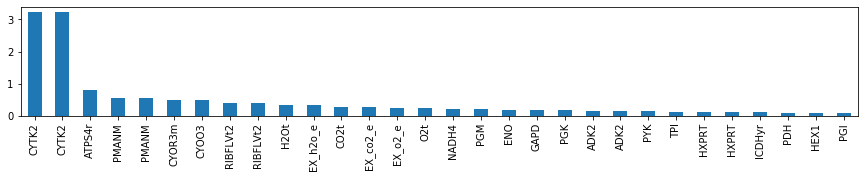

In [1900]:
df = df[0].sort_values(ascending=True).head(30).abs()
df.plot.bar(figsize=(15,2))
plt.xticks(range(len(df.index)), [me.reactions.get_by_id(r).stoichiometric_data.id if hasattr(me.reactions.get_by_id(r),'stoichiometric_data') else r for r in df.index])
plt.savefig('figures/PCA_contributions_amylase.svg',format='SVG')

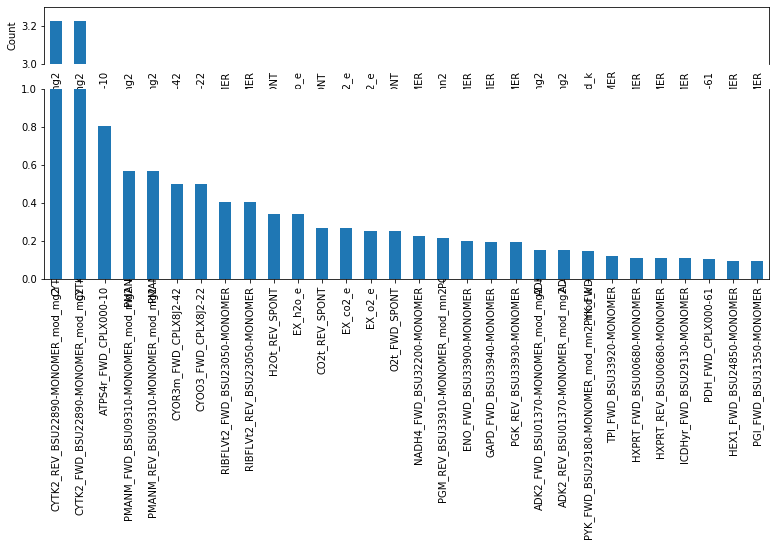

In [1911]:
import matplotlib.pyplot as plt

lims = np.array([0,1,3,3.3])

fig,ax = plt.subplots(2,1,sharex=False,gridspec_kw={'height_ratios': [1,(lims[1]-lims[0])/(lims[3]-lims[2])]},figsize=(15,2))
plt.rcParams['svg.fonttype'] = 'none'

df.plot.bar(legend=False,figsize=(13,5),ax=ax[0])
df.plot.bar(legend=False,figsize=(13,5),ax=ax[1])

ax[0].set_ylim(lims[2], lims[3])  # outliers only
ax[1].set_ylim(lims[0], lims[1])  # most of the data

ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].tick_params(axis='x', which='both',bottom=False)

ax[0].tick_params(labeltop=False)  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()

ax[0].set_ylabel('Count')

plt.savefig('figures/PCA_contributions_amylase.svg',format='SVG')

In [1517]:
df = flux_based_reactions(me,'protein_biomass')
df.head(10)

,lb,ub,rxn_flux,met_flux,reaction
protein_biomass_to_biomass,0,1000,0.0357779,-0.0357779,protein_biomass + 0.5625 unmodeled_protein_bio...
translation_dummy,0,1000,0.000589653,0.0201271,10fthf_c + 0.0012991452991453*mu BSU01120-MONO...
dummy_protein_to_mass,0,1000,0.000589612,-0.0201251,34.13274694 protein_biomass + protein_dummy --...
translation_BSU22890,0,1000,0.00070314,0.0176419,10fthf_c + 0.000952991452991453*mu BSU01120-MO...
translation_BSU14900,0,1000,4.02804e-05,0.00278038,10fthf_c + 0.00265384615384615*mu BSU01120-MON...
translation_BSU22540,0,1000,6.78299e-05,0.00191025,10fthf_c + 0.00108547008547009*mu BSU01120-MON...
translation_BSU22550,0,1000,6.78299e-05,0.00172891,10fthf_c + 0.000952991452991453*mu BSU01120-MO...
translation_BSU14890,0,1000,4.02804e-05,0.00161525,10fthf_c + 0.00151709401709402*mu BSU01120-MON...
translation_BSU22560,0,1000,6.78299e-05,0.0012708,10fthf_c + 0.000709401709401709*mu BSU01120-MO...
translation_BSU14910,0,1000,4.02804e-05,0.000937205,10fthf_c + 0.00088034188034188*mu BSU01120-MON...


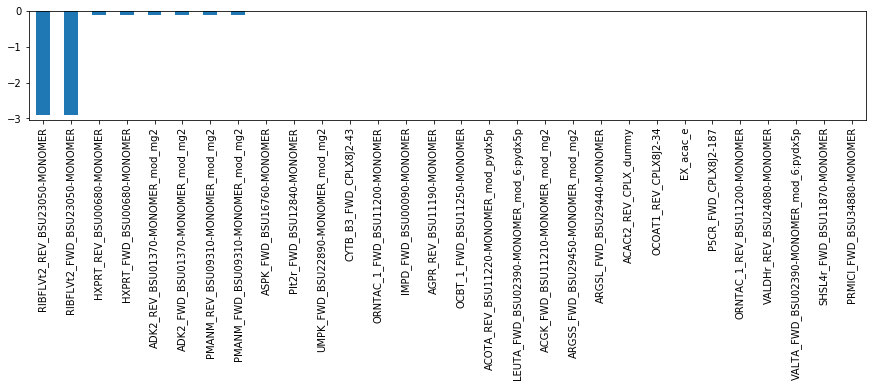

In [1447]:
df[1].sort_values(ascending=True).head(30).plot.bar(figsize=(15,2))

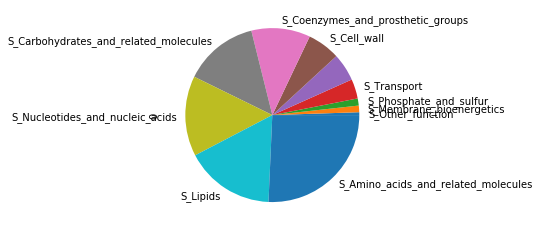

In [1296]:
df[0].sort_values().plot.pie(legend=False)

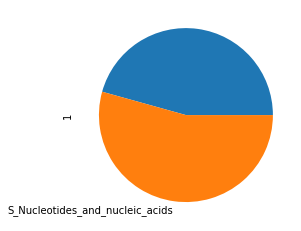

In [1272]:
df[1].sort_values().plot.pie(legend=False)

In [2074]:
for r in me.reactions:
    if 'anaplerotic' in r.subsystem:
        print(r.id)

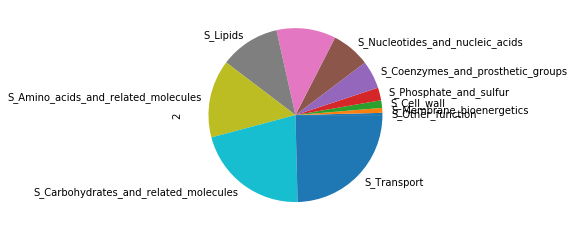

In [1218]:
df[2].sort_values().plot.pie(legend=False)

### Sampling of force amylase

In [7]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [1645]:
ss.add_dummy_demand(me,'BSU03040-MONOMER')
get_reactions_of_met(me,'BSU03040-MONOMER')

( dummy_demand 4.944030075839419e-06 4.944030075839419e-06 ) 	 BSU03040-MONOMER + 72.36591266 protein_biomass --> 
( AAMYL_1_FWD_BSU03040-MONOMER 0 999999.0 ) 	 1.82732695506128e-6*mu BSU03040-MONOMER + starch_e <=> dextrin_e
( formation_BSU03040-MONOMER 0.0 1000.0 ) 	 protein_BSU03040_Inner_Membrane --> BSU03040-MONOMER


[<MEReaction dummy_demand at 0x7f339b096d30>,
 <MetabolicReaction AAMYL_1_FWD_BSU03040-MONOMER at 0x7f33996a9048>,
 <ComplexFormation formation_BSU03040-MONOMER at 0x7f33998c52e8>]

In [20]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('dummy_demand').lower_bound = rate
    me.reactions.get_by_id('dummy_demand').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [21]:
etoh_rates = -np.arange(0,0.6,0.1)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5]
Calculating with 6 cores


,-0.5,-0.4,-0.3,-0.2,-0.1,-0.0
biomass_dilution,0.101699,0.101699,0.101699,0.101699,0.101699,0.101699
protein_biomass_to_biomass,0.026734,0.026710,0.028246,0.030720,0.033221,0.035778
mRNA_biomass_to_biomass,0.000096,0.000095,0.000100,0.000106,0.000112,0.000118
tRNA_biomass_to_biomass,0.000566,0.000566,0.000605,0.000644,0.000681,0.000717
rRNA_biomass_to_biomass,0.004182,0.004179,0.004372,0.004654,0.004924,0.005185


In [3]:
import pandas as pd

In [69]:
flux_responses_me = pd.read_csv('force_amylose_production.csv',index_col=0)

In [8]:
flux_based_reactions(me,'BSU03040-MONOMER',flux_dict=flux_responses_me.iloc[:,0].to_dict())

,lb,ub,rxn_flux,met_flux,reaction
formation_BSU03040-MONOMER,0,1000,8.37087e-07,8.37087e-07,protein_BSU03040_Inner_Membrane --> BSU03040-M...
AAMYL_1_FWD_BSU03040-MONOMER,0,999999,1.32299,-4.18516e-07,1.82732695506128e-6*mu BSU03040-MONOMER + star...


In [1650]:
from sklearn.decomposition import PCA

rxns = [i.id for i in me.reactions if isinstance(i,cobrame.MetabolicReaction) or 'EX_'in i.id or 'dummy' in i.id]
data = flux_responses_me.loc[rxns]
data = data[data.any(axis=1)] # All active reactions
data = data[data.std(axis=1).abs()>0] # Reactions that change
# data = data.abs()
data

,4.1857057163280617e-07,4.196358015645641e-07,4.2070103149632206e-07,4.2176626142808e-07,4.2283149135983796e-07,4.238967212915959e-07,4.2496195122335385e-07,4.260271811551118e-07,4.2709241108686975e-07,4.281576410186277e-07,...,5.155064954227794e-07,5.165717253545374e-07,5.176369552862953e-07,5.187021852180532e-07,5.197674151498112e-07,5.208326450815692e-07,5.218978750133271e-07,5.22963104945085e-07,5.24028334876843e-07,5.25093564808601e-07
EX_co2_e,8.787431e+00,8.787432e+00,8.787433e+00,8.787434e+00,8.787435e+00,8.787436e+00,8.787436e+00,8.787437e+00,8.787438e+00,8.787439e+00,...,8.787338e+00,8.787338e+00,8.787339e+00,8.787350e+00,8.787341e+00,8.787342e+00,8.787343e+00,8.787344e+00,8.787345e+00,8.787346e+00
EX_cobalt2_e,-1.579085e-07,-1.579086e-07,-1.579088e-07,-1.579089e-07,-1.579091e-07,-1.579093e-07,-1.579094e-07,-1.579096e-07,-1.579097e-07,-1.579099e-07,...,-1.579128e-07,-1.579129e-07,-1.579131e-07,-1.579357e-07,-1.579134e-07,-1.579136e-07,-1.579137e-07,-1.579139e-07,-1.579140e-07,-1.579142e-07
EX_fe2_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_h2o_e,1.018455e+01,1.018455e+01,1.018456e+01,1.018456e+01,1.018456e+01,1.018456e+01,1.018457e+01,1.018457e+01,1.018457e+01,1.018457e+01,...,1.018456e+01,1.018456e+01,1.018456e+01,1.018465e+01,1.018457e+01,1.018457e+01,1.018458e+01,1.018458e+01,1.018458e+01,1.018458e+01
EX_h_e,1.336297e+00,1.336298e+00,1.336299e+00,1.336300e+00,1.336301e+00,1.336302e+00,1.336303e+00,1.336304e+00,1.336304e+00,1.336305e+00,...,1.336340e+00,1.336340e+00,1.336341e+00,1.336341e+00,1.336343e+00,1.336344e+00,1.336345e+00,1.336346e+00,1.336346e+00,1.336347e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XPPT_FWD_BSU22070-MONOMER,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-8.009119e-28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
XYLK_FWD_BSU17610-MONOMER_mod_mg2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.750799e-28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
COBALTt5_FWD_SPONT,1.579085e-07,1.579086e-07,1.579088e-07,1.579089e-07,1.579091e-07,1.579093e-07,1.579094e-07,1.579096e-07,1.579097e-07,1.579099e-07,...,1.579128e-07,1.579129e-07,1.579131e-07,1.579357e-07,1.579134e-07,1.579136e-07,1.579137e-07,1.579139e-07,1.579140e-07,1.579142e-07
CBLtex_FWD_BSU33170-MONOMER,9.958499e-09,9.958503e-09,9.958507e-09,9.958511e-09,9.958515e-09,9.958519e-09,9.958523e-09,9.958527e-09,9.958531e-09,9.958535e-09,...,9.958271e-09,9.958275e-09,9.958279e-09,9.958551e-09,9.958287e-09,9.958291e-09,9.958295e-09,9.958299e-09,9.958303e-09,9.958307e-09


In [1914]:
flux_responses_me.loc['biomass_dilution']

4.1857057163280617e-07    0.173117
4.196358015645641e-07     0.173117
4.2070103149632206e-07    0.173117
4.2176626142808e-07       0.173117
4.2283149135983796e-07    0.173117
                            ...   
5.208326450815692e-07     0.173112
5.218978750133271e-07     0.173112
5.22963104945085e-07      0.173112
5.24028334876843e-07      0.173112
5.25093564808601e-07      0.173112
Name: biomass_dilution, Length: 101, dtype: float64

In [1651]:
X = data.values
X.shape

(551, 101)

In [1652]:
X_mean = X.mean(axis=1).reshape(-1,1) * np.ones((1,X.shape[1]))
X_std = X.std(axis=1).reshape(-1,1) * np.ones((1,X.shape[1]))

In [1653]:
X_mean.shape

(551, 101)

In [1654]:
Z = ((X-X_mean)/X_std).T

In [1676]:
pca = PCA(n_components = 3)
pca.fit(Z)
X_ = pca.transform(Z)
var = pca.explained_variance_ratio_
components = pca.components_.T
print(X_.shape,pca.components_.shape,var)

(101, 3) (3, 551) [0.44461391 0.24951897 0.12347861]


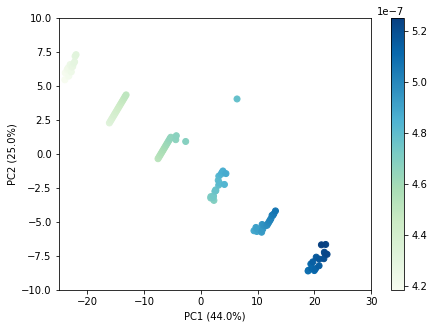

In [1780]:
from matplotlib  import cm
pc_id = [0,1]
x = X_[:,pc_id[0]]
y = X_[:,pc_id[1]]
mu = [float(m) for m in data.columns]
plt.figure(figsize=(7,5))
plt.scatter(x,y,c=mu, marker = 'o', cmap = cm.GnBu)

plt.xlabel('PC{} ({}%)'.format(pc_id[0]+1,round(var[pc_id[0]],2)*100))
plt.ylabel('PC{} ({}%)'.format(pc_id[1]+1,round(var[pc_id[1]],2)*100))
plt.ylim([-10,10])
plt.xlim([-25,30])
plt.colorbar()
plt.savefig('figures/PCA_forced_amylase.svg',format='SVG')

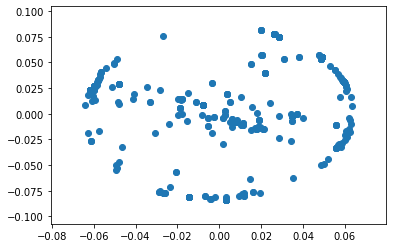

In [1560]:
pc_id = [0,1]
plt.scatter(components[:,pc_id[0]],components[:,pc_id[1]])

In [1662]:
pca_df = pd.DataFrame(data=pca.components_.T,index=data.index)
pca_df.abs().sort_values(by=0,ascending=False).head(10)

,0,1,2
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi,0.063608,0.007239,0.003767
GK1_FWD_BSU15680-MONOMER_mod_mg2,0.062690,0.008228,0.007360
EX_4fe4s_e,0.062633,0.008588,0.011843
ASNS1_FWD_BSU10790-MONOMER,0.062204,0.017309,0.001077
transcription_RNA_dummy,0.062185,0.018853,0.004121
ADK1_FWD_BSU01370-MONOMER_mod_mg2,0.062102,0.005041,0.005618
Kt1_FWD_BSU31322-MONOMER,0.062084,0.017076,0.010416
EX_k_e,0.062084,0.017076,0.010416
GART_FWD_BSU02230-MONOMER_mod_mg2,0.062004,0.019901,0.006354
dummy_protein_to_mass,0.061874,0.020708,0.006159


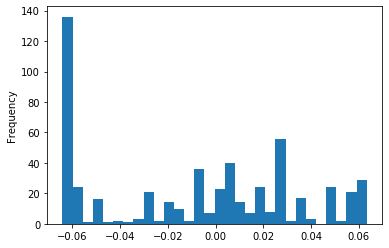

In [1562]:
pca_df[0].sort_values(ascending=False).plot.hist(bins=30)

In [1563]:
rxn_subsystem = defaultdict()
for r in bsub.reactions:
    eco_r = get_identical_reactions(eco,r)
    if eco_r:
        eco_subs = [r.subsystem for r in eco_r]
        rxn_subsystem[r.id] = eco_subs[0]
    else:
        rxn_subsystem[r.id] = r.subsystem

In [1564]:
df = pca_df
# df = df[df[0]> 0.5*df[0].max()]
red_pca_df = df
red_pca_df

,0,1,2
EX_co2_e,-0.059850,0.026540,0.014504
EX_cobalt2_e,-0.048699,-0.053221,-0.007785
EX_fe2_e,-0.007758,0.008198,-0.116624
EX_h2o_e,0.015263,0.048203,0.040567
EX_h_e,0.060170,-0.020326,0.008379
...,...,...,...
XANt2_FWD_BSU22060-MONOMER,0.007758,-0.008198,0.116624
XPPT_FWD_BSU22070-MONOMER,0.007755,-0.008204,0.116624
XYLK_FWD_BSU17610-MONOMER_mod_mg2,0.007739,-0.008254,0.116622
COBALTt5_FWD_SPONT,0.048699,0.053221,0.007785


In [1668]:
X_[i,pc_id[0]]

-23.221740912811335

In [1785]:
from collections import defaultdict
pca_weights = defaultdict(defaultdict)
count_dict = defaultdict(int)
j = 0
for r,row in red_pca_df.iterrows():
    rxn = me.reactions.get_by_id(r)
    m_r = rxn.stoichiometric_data.id if hasattr(rxn,'stoichiometric_data') else rxn.subsystem
    subsystem = rxn_subsystem[m_r] if m_r in rxn_subsystem and 'Unassigned' not in rxn_subsystem[m_r] else rxn.subsystem
#     subsystem = rxn.subsystem
#     subsystem = r
    count_dict[subsystem] += 1
    for i in row.to_dict():
        if subsystem not in pca_weights[int(i)]:
            pca_weights[int(i)][subsystem] = 0
        pca_weights[int(i)][subsystem] += row[i]
    j += 1  

In [1819]:
for r in rxn_subsystem:
    if 'Valine' in rxn_subsystem[r]:
        print(r,rxn_subsystem[r],bsub.reactions.get_by_id(r).reaction)

ACHBS Valine, Leucine, and Isoleucine Metabolism 2obut_c + h_c + pyr_c --> 2ahbut_c + co2_c
ACLS Valine, Leucine, and Isoleucine Metabolism h_c + 2.0 pyr_c --> alac__S_c + co2_c
DHAD1 Valine, Leucine, and Isoleucine Metabolism 23dhmb_c --> 3mob_c + h2o_c
DHAD2 Valine, Leucine, and Isoleucine Metabolism 23dhmp_c --> 3mop_c + h2o_c
ILETA Valine, Leucine, and Isoleucine Metabolism akg_c + ile__L_c <=> 3mop_c + glu__L_c
IPMD Valine, Leucine, and Isoleucine Metabolism 3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c
IPPMIa Valine, Leucine, and Isoleucine Metabolism 3c2hmp_c <=> 2ippm_c + h2o_c
IPPMIb Valine, Leucine, and Isoleucine Metabolism 2ippm_c + h2o_c <=> 3c3hmp_c
IPPS Valine, Leucine, and Isoleucine Metabolism 3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c + h_c
KARA1 Valine, Leucine, and Isoleucine Metabolism 23dhmb_c + nadp_c <=> alac__S_c + h_c + nadph_c
KARA2 Valine, Leucine, and Isoleucine Metabolism 2ahbut_c + h_c + nadph_c <=> 23dhmp_c + nadp_c
LEUTA Valine, Leucine, and Isoleucin

In [1786]:
count_df = pd.DataFrame.from_dict({'count':count_dict})
count_df

,count
,20
Alanine and Aspartate Metabolism,4
Alternate Carbon Metabolism,22
Anaplerotic Reactions,1
Arginine and Proline Metabolism,17
Cell Envelope Biosynthesis,20
Citric Acid Cycle,7
Cofactor and Prosthetic Group Biosynthesis,43
Cysteine Metabolism,7
Folate Metabolism,3


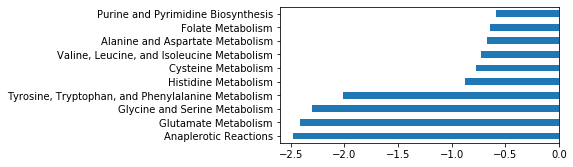

In [1790]:
df = pd.DataFrame.from_dict(pca_weights)
df = df.div(count_df['count'][df.index],axis=0)
df = df.div(df.sum(axis=0),axis=1)

df = df[0].sort_values(ascending=True).head(10)
df.loc[df.abs().sort_values(ascending=False).index].plot.barh(figsize=(5,2.5))
# plt.xticks(range(len(df.index)), [me.reactions.get_by_id(r).stoichiometric_data.id if hasattr(me.reactions.get_by_id(r),'stoichiometric_data') else r for r in df.index])
plt.savefig('figures/PC1_contributions_forced_amylase.svg',format='SVG')

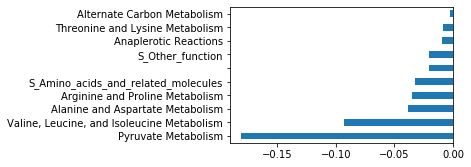

In [1792]:
df = pd.DataFrame.from_dict(pca_weights)
df = df.div(count_df['count'][df.index],axis=0)
df = df.div(df.sum(axis=0),axis=1)

df = df[1].sort_values(ascending=True).head(10)
df.loc[df.abs().sort_values(ascending=False).index].plot.barh(figsize=(4,2.5))
# plt.xticks(range(len(df.index)), [me.reactions.get_by_id(r).stoichiometric_data.id if hasattr(me.reactions.get_by_id(r),'stoichiometric_data') else r for r in df.index])
plt.savefig('figures/PC2_contributions_forced_amylase.svg',format='SVG')

In [1789]:
for r in bsub.reactions:
    if 'Other' in r.subsystem:
        print(r,r.reaction)

26DPAi 23dhdp_c + nad_c --> DPA_c + h_c + nadh_c
BETALDHx betald_c + h2o_c + nad_c --> glyb_c + 2.0 h_c + nadh_c
BLACT h2o_c + pencil_c <=> h_c + pencilca_c
CAT 2.0 h2o2_c --> 2.0 h2o_c + o2_c
CHOLD2 chol_c + fad_c --> betald_c + fadh2_c
FMETTRS_1 10fthf_c + mettrna_c --> fmettrna_c + thf_c
GLUTRS atp_c + glu__L_c + trnaglu_c --> amp_c + glutrna_c + ppi_c
GTHPe 2.0 gthrd_e + h2o2_e <=> gthox_e + 2.0 h2o_e
HCO3E co2_c + h2o_c <=> h_c + hco3_c
METTRS atp_c + met__L_c + trnamet_c --> amp_c + mettrna_c + ppi_c
PENCAC h2o_c + h_c + pencil_c --> 6ampenc_c + for_c
SPODM 2.0 h_c + 2.0 o2s_c <=> h2o2_c + o2_c


In [59]:
d = {'C': 'cys',
 'D': 'asp',
 'S': 'ser',
 'Q': 'gln',
 'K': 'lys',
 'I': 'ile',
 'P': 'pro',
 'T': 'thr',
 'F': 'phe',
 'N': 'asn',
 'G': 'gly',
 'H': 'his',
 'L': 'leu',
 'R': 'arg',
 'W': 'trp',
 'A': 'ala',
 'V': 'val',
 'E': 'glu',
 'Y': 'tyr',
 'M': 'met'}

In [67]:
import Bio
formula = 'MFAKRFKTSLLPLFAGFLLLFHLVLAGPAAASAETANKSNELTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTQIKNWSDRWDVTQNSLLGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSASRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYASDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPDDIAKAPHVFLENYKTGVTHSFNDQLTITLRADANTTKAVYQINNGPETAFKDGDQFTIGKGDPFGKTYTIMLKGTNSDGVTRTEKYSFVKRDPASAKTIGYQNPNHWSQVNAYIYKHDGSRVIELTGSWPGKPMTKNADGIYTLTLPADTDTTNAKVIFNNGSAQVPGQNQPGFDYVLNGLYNDSGLSGSLPH'
def get_amino_acids_percent(formula):
    d = {}
    for i in formula:
        if i not in d: d[i] = 0
        d[i] += 1
    df = pd.DataFrame.from_dict({'percent':d})
    return df.div(df.sum())['percent'].to_dict()
met_info = {}
for aa,met_comp in get_amino_acids_percent(formula).items():
    met_id = d[aa] + '__L_c' if aa != 'G' else 'gly_c'    
    met_info[met_id] = {}
    met_info[met_id]['met_comp'] = met_comp

In [68]:
all_mets = [m.id for m in bsub.metabolites]
sp_dict = {}
for aa in met_info.keys():
    idx = all_mets.index(aa)
    sp = bsub.solution.y[idx]
    met_info[aa]['shadow_price'] = sp

In [70]:
# from sklearn.linear_model import LinearRegression
from collections import defaultdict

met_sensitivity = {}
for met_id,met_rate,dummy_rate in get_met_production(me,met_info.keys(),flux_responses_me,'dummy_demand',only_types = ['MetabolicReaction'],plot=False):
#     reg = LinearRegression().fit(np.array(uptake_rate).reshape(-1,1),np.array(met_rate).reshape(-1,1))
    met_info[met_id]['change'] = met_rate[-1]-met_rate[0]
    met_info[met_id]['met_rate'] = np.array(met_rate)
    met_info[met_id]['dummy_rate'] = np.array(dummy_rate)

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


In [78]:
dummy_change = flux_responses_me.loc['dummy_demand'].values[-1] - flux_responses_me.loc['dummy_demand'].values[0]
dummy_change

1.0652299317579479e-07

In [83]:
df = pd.DataFrame.from_dict(met_info).T[['met_comp','shadow_price','change']]
df

,met_comp,shadow_price,change
ala__L_c,0.0880121,-0.0417334,1.37746e-06
cys__L_c,0.00151745,-0.0714105,-2.54262e-08
asp__L_c,0.0682853,-0.0463704,2.18538e-05
glu__L_c,0.0349014,-0.0677008,4.64998e-05
phe__L_c,0.0409712,-0.156732,1.5906e-06
gly_c,0.0849772,-0.0259674,2.84736e-06
his__L_c,0.0257967,-0.102942,1.22369e-06
ile__L_c,0.0515933,-0.113144,1.35509e-06
lys__L_c,0.0515933,-0.106652,1.39168e-06
leu__L_c,0.0652504,-0.10387,3.97707e-05


In [82]:
df.to_csv('amylase_results.csv')

<AxesSubplot:>

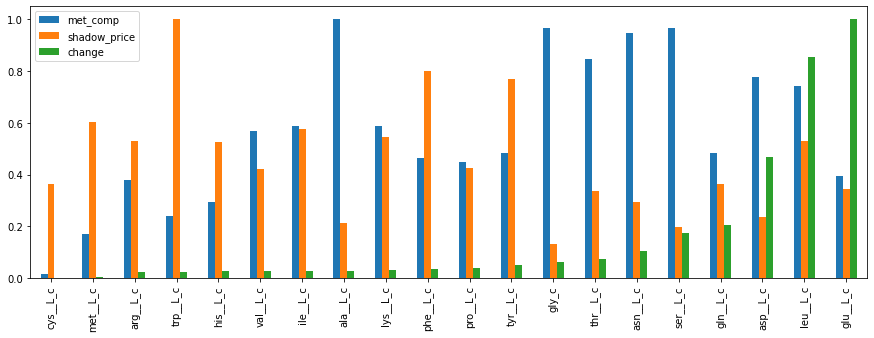

In [73]:
df.div(df.abs().max()).abs().sort_values(by='change').plot.bar(figsize=(15,5))

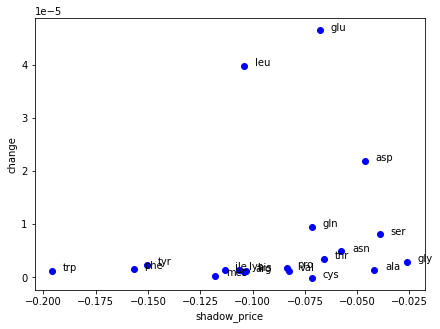

In [75]:
fig = plt.figure(figsize=(7,5))
for met_id,row in df.iterrows():
    plt.plot(row['shadow_price'],row['change'],'ob')
    plt.text(row['shadow_price']+0.005,row['change'],met_id[:3])
    plt.xlabel('shadow_price')
    plt.ylabel('change')

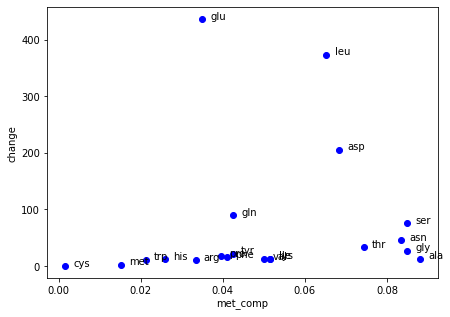

In [80]:
fig = plt.figure(figsize=(7,5))
for met_id,row in df.iterrows():
    plt.plot(row['met_comp'],row['change']/dummy_change,'ob')
    plt.text(row['met_comp']+0.002,row['change']/dummy_change,met_id[:3])
    
    plt.xlabel('met_comp')
    plt.ylabel('change')

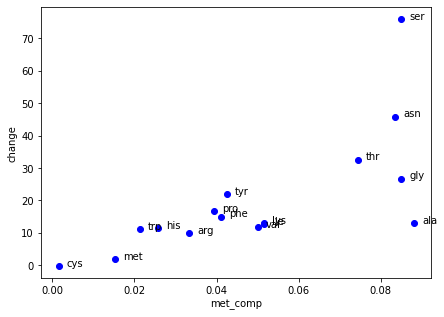

In [87]:
fig = plt.figure(figsize=(7,5))
exclude = ['glu__L_c','leu__L_c','asp__L_c','gln__L_c']
for met_id,row in df.iterrows():
    if met_id in exclude: continue
    plt.plot(row['met_comp'],row['change']/dummy_change,'ob')
    plt.text(row['met_comp']+0.002,row['change']/dummy_change,met_id[:3])
    
    plt.xlabel('met_comp')
    plt.ylabel('change')

In [ ]:
fig = plt.figure(figsize=(7,5))
for met_id,row in df.iterrows():
    plt.plot(row['met_comp'],row['change'],'ob')
    plt.text(row['met_comp']+0.002,row['change'],met_id[:3])
    
    plt.xlabel('met_comp')
    plt.ylabel('change')

In [2092]:
fig.savefig('change_met_comp_amylase.svg',format='SVG')

Text(0.5, 0, 'change')

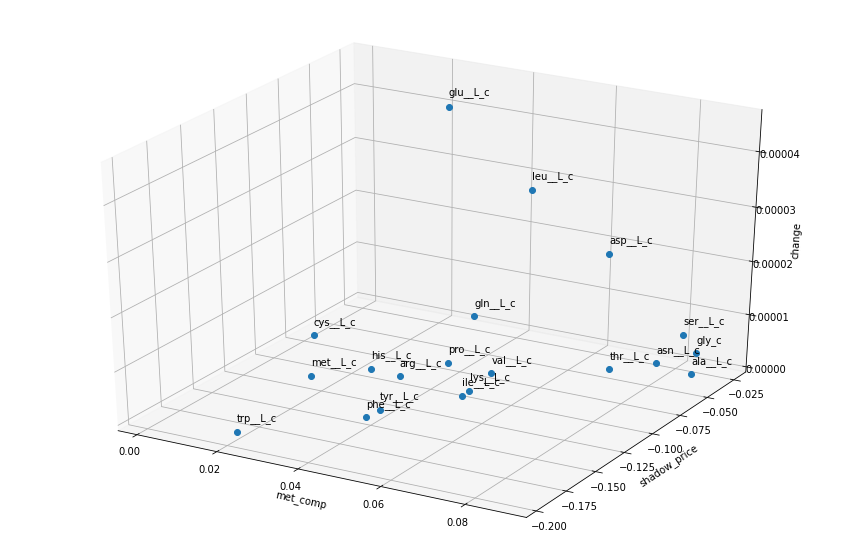

In [2069]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

    
x = np.array(df['met_comp'])
y = np.array(df['shadow_price'])
z = np.array(df['change'])
ax.plot3D(x,y,z,'o')

for idx,met in enumerate(list(df.index)):
    ax.text(x[idx], y[idx], z[idx]+0.2e-5, met)

ax.set_xlabel('met_comp')
ax.set_ylabel('shadow_price')
ax.set_zlabel('change')

## Amylase experiments

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

In [6]:
df = pd.read_csv('amylase_data.csv',index_col=0).sort_values('OD405')
df.head()

,OD405,STD
aa,,
Cys,0.06723,0.001775
starch,0.07507,0.001204
Gly,0.07557,0.002053
Leu,0.07567,0.002290
Phe,0.07600,0.002609


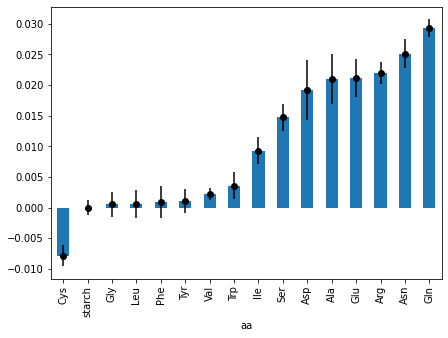

In [7]:
reduced = (df['OD405']-df['OD405']['starch'])
fig, ax = plt.subplots(figsize=(7,5))
reduced.plot.bar()
ax.errorbar(reduced.index, reduced.values, yerr=df['STD'].values, fmt='o', color='k')
fig.savefig('experimental_amylase_data.svg',format='SVG')

In [221]:
df = pd.read_csv('Supplementary File 3.csv',index_col=0)

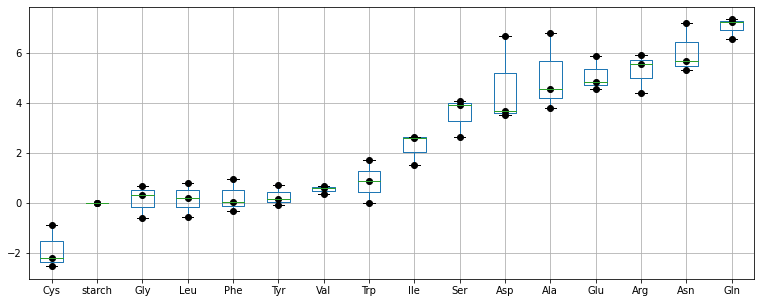

In [222]:
standard = 0.016642
rel = (df - df.loc['starch']) / standard / (5*0.05)
rel = rel.loc[rel.mean(axis=1).sort_values().index].T
fig, ax = plt.subplots(figsize=(13,5))
rel.boxplot()
for i,d in enumerate(rel):
    y = rel[d]
    x = i*np.ones(len(y)) + 1
    plt.plot(x, y, color='k', marker="o", linestyle="None")
fig.savefig('experimental_amylase_data_box.svg',format='SVG')

In [56]:
rel.T

,sample1,sample2,sample3
aa,,,
Cys,-0.636943,-0.552818,-0.222329
starch,0.000000,0.000000,0.000000
Gly,-0.156231,0.168249,0.078116
Leu,-0.138205,0.198293,0.048071
Phe,-0.078116,0.240356,0.006009
Tyr,-0.024036,0.180267,0.036053
Val,0.084125,0.162240,0.150222
Trp,0.216320,0.000000,0.426631
Ile,0.660978,0.372551,0.642952


In [65]:
for a,row in rel.T.iterrows():
    x = row.values
    y = rel['starch'].values
    t = ttest_ind(x,y)
    print(a,t.pvalue)

Cys 0.02047696360256672
starch nan
Gly 0.7715563668718043
Leu 0.7298329291638092
Phe 0.5877647041248042
Tyr 0.3499957899834208
Val 0.005529885194973436
Trp 0.15681513277890477
Ile 0.003904774661936705
Ser 0.0014342848518267154
Asp 0.01071914934426895
Ala 0.004904259603584852
Glu 0.0002243550837767433
Arg 0.0003050837934989977
Asn 0.00048715932776359136
Gln 8.294221361338496e-06


In [42]:
rel[d]

sample1    1.808677
sample2    1.640428
sample3    1.832712
Name: Gln, dtype: float64

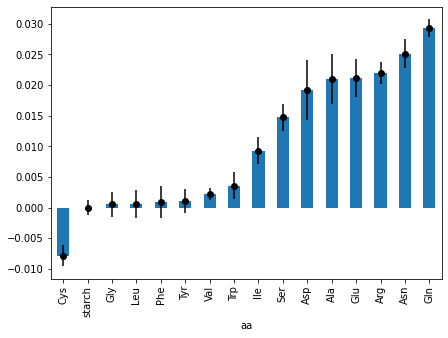

In [43]:
reduced = (df['OD405']-df['OD405']['starch'])
fig, ax = plt.subplots(figsize=(7,5))
reduced.plot.bar()
ax.errorbar(reduced.index, reduced.values, yerr=df['STD'].values, fmt='o', color='k')
fig.savefig('experimental_amylase_data.svg',format='SVG')

In [79]:
flux_based_reactions(me,'cys__L_c',flux_dict=flux_responses_me.iloc[:,0].to_dict(),only_types = ['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p,0,999999,0.00435578,0.00435578,4.27350427350427e-6*mu BSU27250-MONOMER_mod_py...
HEMECS_FWD_CPLX_dummy,0,999999,0,-0,4.27350427350427e-6*mu CPLX_dummy + 2.0 cys__L...
BIOMASS_BS_10_FWD_CPLX_dummy,0,0,0,-0,0.000367 10fthf_c + 4.27350427350427e-6*mu CPL...
PPNCL_FWD_BSU15700-MONOMER,0,999999,0,-0,4ppan_c + 3.22695132810028e-6*mu BSU15700-MONO...
CYSS_2_FWD_BSU00730-MONOMER_mod_2:pydx5p,0,999999,0,0,8.58171771088816e-6*mu BSU00730-MONOMER_mod_2:...
AHSERL4_FWD_BSU00730-MONOMER_mod_2:pydx5p,0,999999,0,0,4.27350427350427e-6*mu BSU00730-MONOMER_mod_2:...
AHSERL4_REV_BSU00730-MONOMER_mod_2:pydx5p,0,999999,0,-0,4.27350427350427e-6*mu BSU00730-MONOMER_mod_2:...
TRPAS1_FWD_BSU27250-MONOMER_mod_pydx5p,0,999999,0,-0,4.34718776686646e-6*mu BSU27250-MONOMER_mod_py...
CYSabc_FWD_CPLX_dummy,0,999999,0,0,4.27350427350427e-6*mu CPLX_dummy + atp_c + cy...
SHSL1_FWD_BSU11870-MONOMER,0,999999,0,-0,4.27350427350427e-6*mu BSU11870-MONOMER + cys_...


In [80]:
flux_based_reactions(me,'cys__L_c',flux_dict=flux_responses_me.iloc[:,-1].to_dict(),only_types = ['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p,0,999999,0.00435575,0.00435575,4.27350427350427e-6*mu BSU27250-MONOMER_mod_py...
HEMECS_FWD_CPLX_dummy,0,999999,0,-0,4.27350427350427e-6*mu CPLX_dummy + 2.0 cys__L...
BIOMASS_BS_10_FWD_CPLX_dummy,0,0,0,-0,0.000367 10fthf_c + 4.27350427350427e-6*mu CPL...
PPNCL_FWD_BSU15700-MONOMER,0,999999,0,-0,4ppan_c + 3.22695132810028e-6*mu BSU15700-MONO...
CYSS_2_FWD_BSU00730-MONOMER_mod_2:pydx5p,0,999999,0,0,8.58171771088816e-6*mu BSU00730-MONOMER_mod_2:...
AHSERL4_FWD_BSU00730-MONOMER_mod_2:pydx5p,0,999999,0,0,4.27350427350427e-6*mu BSU00730-MONOMER_mod_2:...
AHSERL4_REV_BSU00730-MONOMER_mod_2:pydx5p,0,999999,0,-0,4.27350427350427e-6*mu BSU00730-MONOMER_mod_2:...
TRPAS1_FWD_BSU27250-MONOMER_mod_pydx5p,0,999999,0,-0,4.34718776686646e-6*mu BSU27250-MONOMER_mod_py...
CYSabc_FWD_CPLX_dummy,0,999999,0,0,4.27350427350427e-6*mu CPLX_dummy + atp_c + cy...
SHSL1_FWD_BSU11870-MONOMER,0,999999,0,-0,4.27350427350427e-6*mu BSU11870-MONOMER + cys_...


In [75]:
flux_responses_me

,4.1857057163280617e-07,4.196358015645641e-07,4.2070103149632206e-07,4.2176626142808e-07,4.2283149135983796e-07,4.238967212915959e-07,4.2496195122335385e-07,4.260271811551118e-07,4.2709241108686975e-07,4.281576410186277e-07,...,5.155064954227794e-07,5.165717253545374e-07,5.176369552862953e-07,5.187021852180532e-07,5.197674151498112e-07,5.208326450815692e-07,5.218978750133271e-07,5.22963104945085e-07,5.24028334876843e-07,5.25093564808601e-07
biomass_dilution,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,1.731167e-01,...,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01,1.731119e-01
protein_biomass_to_biomass,6.007422e-02,6.007421e-02,6.007421e-02,6.007420e-02,6.007420e-02,6.007419e-02,6.007418e-02,6.007418e-02,6.007417e-02,6.007417e-02,...,6.007210e-02,6.007210e-02,6.007209e-02,6.007198e-02,6.007208e-02,6.007208e-02,6.007207e-02,6.007206e-02,6.007206e-02,6.007205e-02
mRNA_biomass_to_biomass,2.272137e-04,2.272139e-04,2.272140e-04,2.272142e-04,2.272144e-04,2.272145e-04,2.272147e-04,2.272149e-04,2.272151e-04,2.272152e-04,...,2.272210e-04,2.272212e-04,2.272214e-04,2.272228e-04,2.272217e-04,2.272219e-04,2.272220e-04,2.272222e-04,2.272224e-04,2.272225e-04
tRNA_biomass_to_biomass,1.380852e-03,1.380853e-03,1.380854e-03,1.380855e-03,1.380856e-03,1.380857e-03,1.380858e-03,1.380859e-03,1.380860e-03,1.380861e-03,...,1.380897e-03,1.380898e-03,1.380899e-03,1.380908e-03,1.380901e-03,1.380902e-03,1.380903e-03,1.380904e-03,1.380905e-03,1.380906e-03
rRNA_biomass_to_biomass,9.981530e-03,9.981538e-03,9.981545e-03,9.981552e-03,9.981560e-03,9.981567e-03,9.981575e-03,9.981582e-03,9.981590e-03,9.981597e-03,...,9.981853e-03,9.981860e-03,9.981868e-03,9.981920e-03,9.981883e-03,9.981890e-03,9.981897e-03,9.981905e-03,9.981912e-03,9.981920e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
translocation_BSU39450,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
translocation_BSU39710,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
translocation_BSU40070,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
translocation_BSU40330,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [78]:
get_met_production(me,['cys__L_c'],flux_responses_me,'dummy_demand',only_types = ['MetabolicReaction'])

<generator object get_met_production at 0x7f4723783bf8>

### Sampling at high and low amylase

In [113]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [114]:
flux_responses_me = pd.read_csv('force_amylose_production.csv',index_col=0)

In [115]:
ss.add_dummy_demand(me,'BSU03040-MONOMER')
get_reactions_of_met(me,'BSU03040-MONOMER')

( AAMYL_1_FWD_BSU03040-MONOMER 0 999999.0 ) 	 1.82732695506128e-6*mu BSU03040-MONOMER + starch_e --> dextrin_e
( dummy_demand 4.944031588161544e-06 4.944031588161544e-06 ) 	 BSU03040-MONOMER + 72.36591266 protein_biomass --> 
( formation_BSU03040-MONOMER 0.0 1000.0 ) 	 protein_BSU03040_Inner_Membrane --> BSU03040-MONOMER


[<MetabolicReaction AAMYL_1_FWD_BSU03040-MONOMER at 0x7f659f064ef0>,
 <MEReaction dummy_demand at 0x7f66a8eb2fd0>,
 <ComplexFormation formation_BSU03040-MONOMER at 0x7f667d2d2278>]

In [116]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('dummy_demand').lower_bound = rate
    me.reactions.get_by_id('dummy_demand').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [117]:
v_exp_min_chen = 2.7708397827250746e-07
v_exp_max_chen = 4.416758274350314e-07

v_exp_min_ma = 8.499771931672557e-09
v_exp_max_ma = 1.354875812140388e-08

In [ ]:
rates = v_exp_max_chen + (0.1)*v_exp_max_chen*np.random.random_sample(100)
new_mu = False
flux_dict = dict()

import multiprocessing as mp
NP = min([len(rates),20])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me_high = pd.DataFrame.from_dict(flux_dict)
flux_responses_me_high = flux_responses_me_high[sorted(flux_responses_me_high.columns)]
flux_responses_me_high.head()

Calculating with 20 cores


In [ ]:
flux_responses_me_high.to_csv('sampling_high_amylase.csv')

In [ ]:
rates = v_exp_max_ma + (0.1)*v_exp_max_chen*np.random.random_sample(100)
new_mu = False
flux_dict = dict()

import multiprocessing as mp
NP = min([len(rates),20])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me_low = pd.DataFrame.from_dict(flux_dict)
flux_responses_me_low = flux_responses_me_low[sorted(flux_responses_me_low.columns)]
flux_responses_me_low.head()

In [ ]:
flux_responses_me_low.to_csv('sampling_low_amylase.csv')

In [ ]:
r = 'CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p'
flux_responses_me_low.loc[r].hist(bins=100)
flux_responses_me_high.loc[r].hist(bins=100,color='g')

In [ ]:
r = 'dummy_demand'
flux_responses_me_high.loc[r].hist(bins=30,color='k')
flux_responses_me_low.loc[r].hist(bins=30)

In [138]:
from scipy.stats import ttest_ind
r = 'CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p'
x = flux_responses_me_high.loc[r].values
y = flux_responses_me_low.loc[r].values
t = ttest_ind(x,y)
t

Ttest_indResult(statistic=-31.41299615553123, pvalue=1.2404512052654551e-86)

In [224]:
df = flux_responses_me_low.loc[r].to_frame().reset_index(drop=True).join(
        flux_responses_me_high.loc[r].to_frame().reset_index(drop=True),lsuffix='_low',rsuffix='_high')
df = df - df.min().min()

In [225]:
row

CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p_low     9.748360e-08
CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p_high    6.750811e-10
Name: 99, dtype: float64

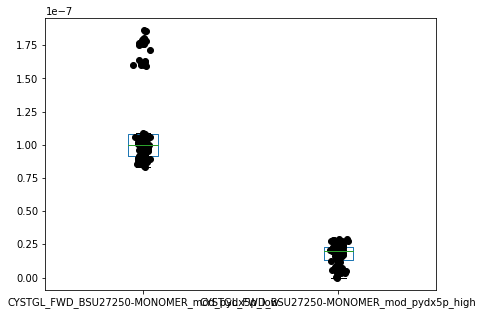

In [226]:
fig, ax = plt.subplots(figsize=(7,5))
df.boxplot(showfliers=False,grid=False)
plt.plot(np.random.normal(1, 0.02, len(df)),df.iloc[:,0],'o',color = 'k')
plt.plot(np.random.normal(2, 0.02, len(df)),df.iloc[:,1],'o',color = 'k')
fig.savefig('sampling_cysteine_boxplot.svg',format='SVG')

In [142]:
(np.mean(x) - np.mean(y))/(flux_responses_me_high.loc['dummy_demand'].mean() - flux_responses_me_low.loc['dummy_demand'].mean())

-0.22723304810973163

In [139]:
np.mean(y)

0.0021509852008829962

In [140]:
np.mean(x)

0.0021508876243137042

In [218]:
flux_responses_me_low.mean(axis=1) - flux_responses_me_high.mean(axis=1)

biomass_dilution              2.197266e-05
protein_biomass_to_biomass    9.575198e-06
mRNA_biomass_to_biomass      -2.983060e-08
tRNA_biomass_to_biomass      -1.833706e-07
rRNA_biomass_to_biomass      -1.313563e-06
                                  ...     
translocation_BSU39450        0.000000e+00
translocation_BSU39710        0.000000e+00
translocation_BSU40070        0.000000e+00
translocation_BSU40330        0.000000e+00
dummy_demand                 -4.294119e-07
Length: 6278, dtype: float64

In [204]:
df_low = flux_based_reactions(me,'cys__L_c',flux_dict=flux_responses_me_low.mean(axis=1).to_frame().to_dict()[0])
df_low = df_low[df_low.met_flux<0]

In [205]:
df_high = flux_based_reactions(me,'cys__L_c',flux_dict=flux_responses_me_high.mean(axis=1).to_frame().to_dict()[0])
df_high = df_high[df_high.met_flux<0]

In [209]:
df_high.met_flux - df_low.met_flux

CYSabc_FWD_CPLX_dummy                    NaN
PPNCL_FWD_BSU15700-MONOMER      -8.10259e-19
charging_tRNA_BSU_tRNA_42_UGC    1.71539e-11
charging_tRNA_BSU_tRNA_42_UGU   -6.06473e-12
translation_BSU00090             9.37134e-12
                                    ...     
translation_BSU39860             3.01444e-12
translation_BSU40420            -3.10493e-12
translation_BSU40550             2.45103e-10
translation_BSU40890            -8.96604e-10
translation_dummy                3.15606e-07
Name: met_flux, Length: 348, dtype: object

In [212]:
df_high['met_flux'].sum() - df_low['met_flux'].sum()

9.757656928895825e-08

In [213]:
df_high['met_flux']

translation_dummy        -0.00117896
translation_BSU22560    -0.000271236
translation_BSU14890     -0.00020134
translation_BSU22540    -0.000135618
translation_BSU22550    -6.78091e-05
                            ...     
translation_BSU03900    -2.88938e-34
translation_BSU30960    -3.22713e-35
translation_BSU35580    -5.58043e-37
CYSabc_FWD_CPLX_dummy   -2.79747e-37
translation_BSU32510    -2.71416e-39
Name: met_flux, Length: 346, dtype: object

In [187]:
df_high['met_flux'] - df_low['met_flux']

AHSERL4_FWD_BSU00730-MONOMER_mod_2:pydx5p              0
AHSERL4_REV_BSU00730-MONOMER_mod_2:pydx5p              0
BIOMASS_BS_10_FWD_CPLX_dummy                           0
CYSS_2_FWD_BSU00730-MONOMER_mod_2:pydx5p               0
CYSTGL_FWD_BSU27250-MONOMER_mod_pydx5p      -9.75766e-08
                                                ...     
translation_BSU40420                        -3.10493e-12
translation_BSU40550                         2.45103e-10
translation_BSU40850                                   0
translation_BSU40890                        -8.96604e-10
translation_dummy                            3.15606e-07
Name: met_flux, Length: 804, dtype: object